In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
# from pmdarima import auto_arima
import warnings

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("WARNING: 'prophet' library not found. The Prophet section will be skipped.")
    print("Install it via: pip install prophet")

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Install it via: pip install prophet


## Helper functions

In [2]:
dow_map = [datetime.strftime(datetime(1,1,i+1), "%A") for i in range(7)]
month_map = [datetime.strftime(datetime(1,i+1,1), "%B") for i in range(12)]

In [3]:
aqi_map = [
    "Good", 
    "Moderate", 
    "Unhealthy for Sensitive Groups",
    "Unhealthy",
    "Very Unhealthy",
    "Hazardous"
]
def get_aqi_category(aqi, as_strings=False):
    """Returns the textual category for a given AQI value (US Standard)."""
    if aqi is None or np.isnan(aqi): return None
    val = int(aqi); aqi_idx = 5
    if val <= 50: aqi_idx = 0
    elif val <= 100: aqi_idx = 1
    elif val <= 150: aqi_idx = 2
    elif val <= 200: aqi_idx = 3
    elif val <= 300: aqi_idx = 4
    if as_strings: return aqi_map[aqi_idx]
    return aqi_idx

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def check_stationarity(series):
    # From https://machinelearningmastery.com/time-series-data-stationary-python/
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

## 1. Setup Data

In [5]:
df = pd.read_csv("./data/clean_data.csv")
# Time to datetime index
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")
df.set_index("time", inplace=True)
# Set freq
df.index.freq="1H"
# Convert month and day-of-week to numbers
df["month"] = df.index.month - 1
df["day_of_week"] = df.index.weekday
# Sort to make sure
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28865 entries, 2022-08-05 07:00:00 to 2025-11-19 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature_2m        28865 non-null  float64
 1   relative_humidity_2m  28865 non-null  int64  
 2   rain                  28865 non-null  float64
 3   wind_direction_10m    28865 non-null  int64  
 4   wind_speed_10m        28865 non-null  float64
 5   aqi_pm25              28865 non-null  float64
 6   hour                  28865 non-null  int64  
 7   month                 28865 non-null  int32  
 8   day_of_week           28865 non-null  int32  
 9   is_weekend            28865 non-null  bool   
 10  is_raining            28865 non-null  bool   
dtypes: bool(2), float64(4), int32(2), int64(3)
memory usage: 2.0 MB


### 2. EDA

### 2.1. PM2.5 vs Time

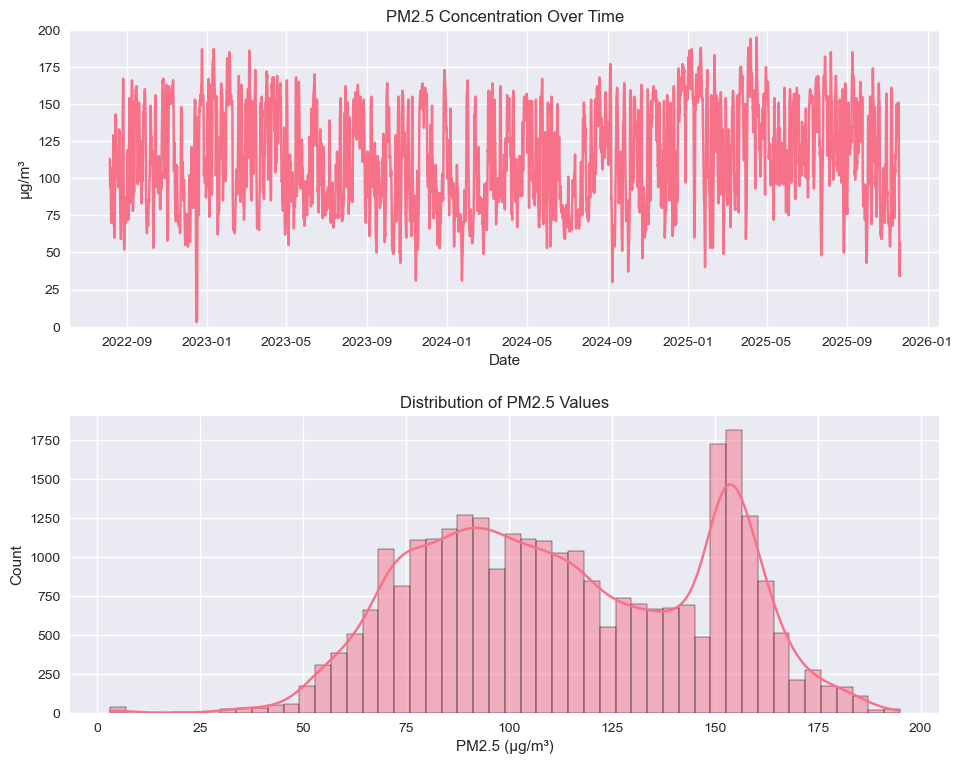

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
# Values over time
ax[0].plot(df.index, df["aqi_pm25"], label="PM2.5 Concentration")
ax[0].set(
    title="PM2.5 Concentration Over Time",
    xlabel="Date",
    ylabel="µg/m³", ylim=[0,200]
)
# Distribution over time
sns.histplot(df["aqi_pm25"], kde=True, bins=50, ax=ax[1])
ax[1].set(
    title="Distribution of PM2.5 Values",
    xlabel="PM2.5 (µg/m³)",
)
fig.tight_layout(pad=2.0)
fig.show()

In [7]:
# Check stationary
check_stationarity(df["aqi_pm25"])

ADF Statistic: -13.536176
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


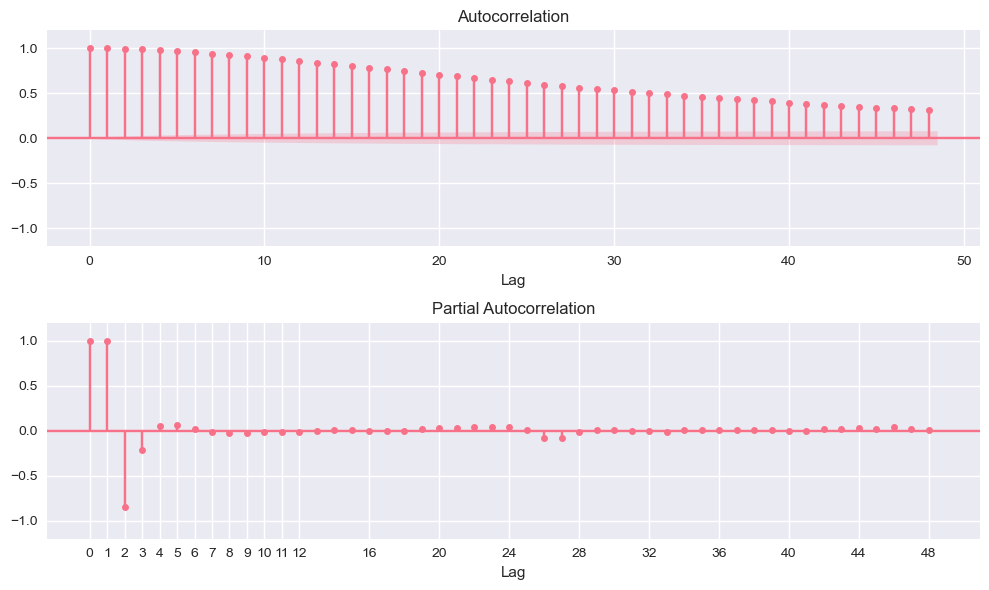

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 2*3))
plot_acf(df["aqi_pm25"], lags=48, ax=axes[0])
plot_pacf(df["aqi_pm25"], lags=48, ax=axes[1])
for ax in axes: ax.set_ylim([-1.2, 1.2]); ax.set(xlabel="Lag")
axes[1].set_xticks([i for i in range(12)] + [i for i in range(12, 49, 4)])
plt.tight_layout()
plt.show()

### 2.2. PM2.5 vs TimeCycle

#### 2.2.1. PM2.5 vs Hours

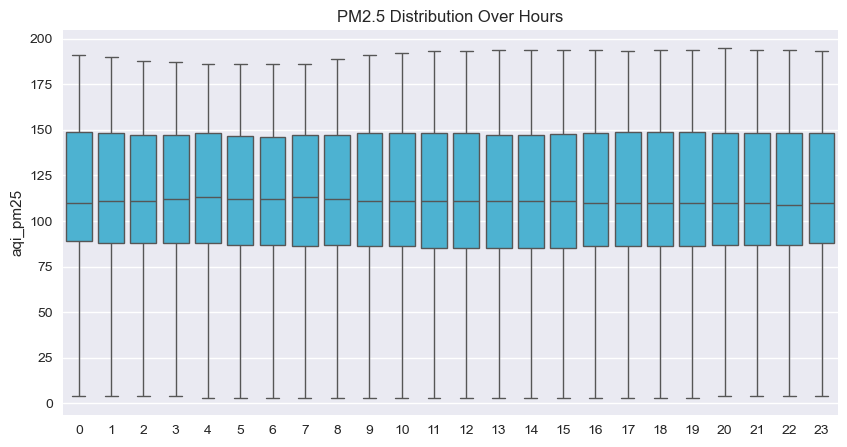

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(df, x="hour", y="aqi_pm25", ax=ax, color="#37BEE7")
ax.set(xlabel=None, title="PM2.5 Distribution Over Hours")
ax.set_xticks(range(24))
plt.show()

In [10]:
df_is_hour = df["hour"].apply(
    lambda x: pd.Series(
        {f"is_hour_{i}": x==i 
        for i in range(24)}
    ))

corr_by_hour = df_is_hour.corrwith(df["aqi_pm25"])
print(f"Max absolute correlation by Hours: {max(abs(corr_by_hour)):.5f}")

Max absolute correlation by Hours: 0.00282


#### 2.2.2. PM2.5 vs DOW

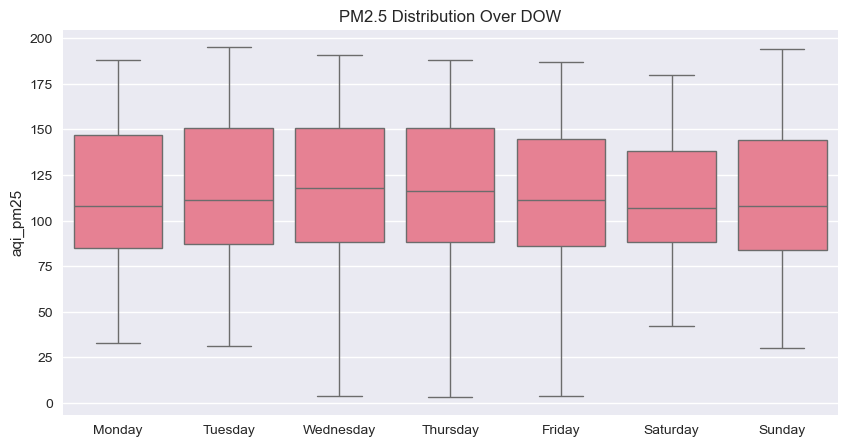

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(df, x="day_of_week", y="aqi_pm25", ax=ax)
ax.set(xlabel=None, title="PM2.5 Distribution Over DOW")
ax.set_xticks(range(7), dow_map)
plt.show()

In [12]:
df_is_dow = df["day_of_week"].apply(
    lambda x: pd.Series(
        {f"is_{dow_map[i].lower()}": x==i 
        for i in range(7)}
    ))
corr_by_dow = df_is_dow.corrwith(df["aqi_pm25"])
print(f"Max absolute correlation by DOW: {max(abs(corr_by_dow)):.5f}")

Max absolute correlation by DOW: 0.03765


#### 2.2.3. PM2.5 vs Month

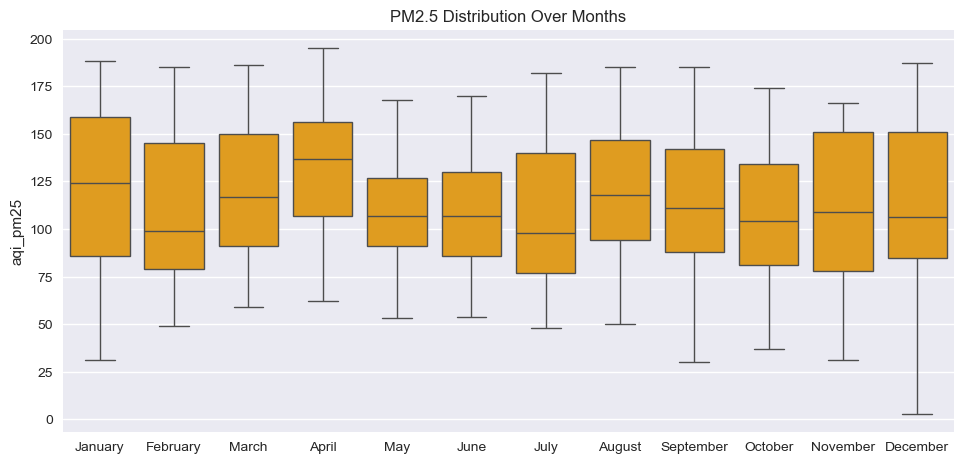

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(df, x="month", y="aqi_pm25", ax=ax, color="orange")
ax.set(xlabel=None, title="PM2.5 Distribution Over Months",)
ax.set_xticks(range(12), month_map)
fig.tight_layout(pad=2.0)
fig.show()

In [14]:
df_is_month = df["month"].apply(
    lambda x: pd.Series(
        {f"is_{month_map[i].lower()}": x==i 
        for i in range(12)}
    ))
corr_by_month = df_is_month.corrwith(df["aqi_pm25"])
print(f"Max absolute correlation by Months: {max(abs(corr_by_month)):.5f}")

Max absolute correlation by Months: 0.14851


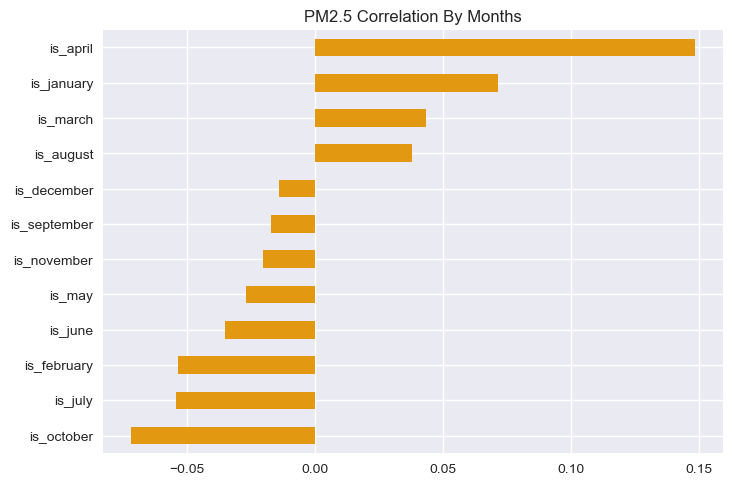

In [15]:
corr_by_month.sort_values().plot(
    kind="barh",
    color="#E29911",
    title="PM2.5 Correlation By Months")
plt.show()

### 2.3. PM2.5 vs Wind (Speed & Direction)

In [16]:
print("Wind direction range:\t[{}, {}]".format(
    df["wind_direction_10m"].min(), df["wind_direction_10m"].max()
))
print("Wind speed range:\t[{}, {}]".format(
    df["wind_speed_10m"].min(), df["wind_speed_10m"].max()
))

Wind direction range:	[1, 360]
Wind speed range:	[0.0, 60.7]


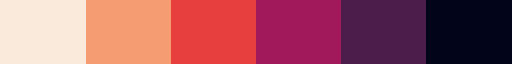

In [17]:
cmap = sns.color_palette("rocket_r", as_cmap=True).resampled(6)
cmap

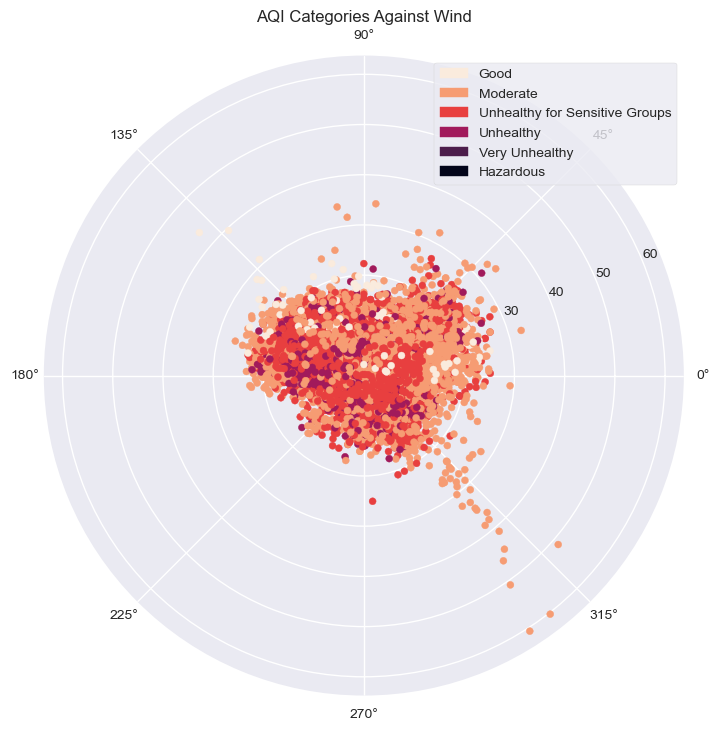

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = (df["wind_direction_10m"] % 360) * np.pi / 180
radii = df["wind_speed_10m"]
aqi_category = df["aqi_pm25"].apply(get_aqi_category)

scatter = ax.scatter(
    theta, radii,
    c=cmap(aqi_category), s=25.0,
)
ax.legend(handles=[
    mpatches.Patch(color=cmap(i),label=aqi_map[i])
    for i in range(len(aqi_map))
], loc="upper right", frameon=True)
ax.set(title="AQI Categories Against Wind")
plt.show()

In [19]:
def get_wind_components(x):
    theta = (x["wind_direction_10m"] % 360) / 180 * np.pi 
    return pd.Series({
        "wind_sin": np.sin(theta),
        "wind_cos": np.cos(theta),
        "wind_speed": x["wind_speed_10m"]
    })

df_wind_comps = df.apply(get_wind_components, axis=1) 
df_wind_comps.head()

,wind_sin,wind_cos,wind_speed
time,,,
2022-08-05 07:00:00,0.358368,0.933580,6.2
2022-08-05 08:00:00,0.156434,0.987688,6.6
2022-08-05 09:00:00,0.139173,0.990268,5.1
2022-08-05 10:00:00,0.469472,0.882948,5.3
2022-08-05 11:00:00,0.224951,0.974370,4.8


In [23]:
df_wind_comps.corrwith(df["aqi_pm25"])

wind_sin      0.000420
wind_cos     -0.111836
wind_speed   -0.303790
dtype: float64

### 2.4. PM2.5 vs Temperature+Humidity

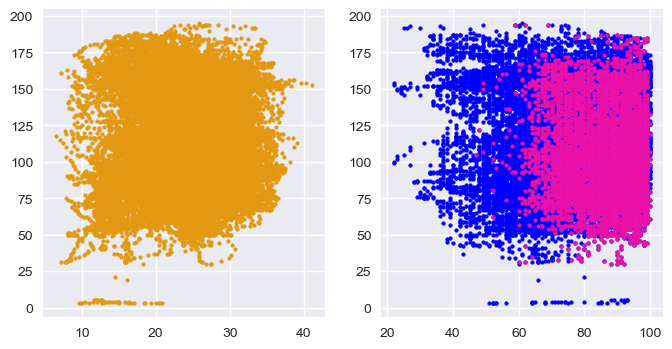

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].scatter(
    df["temperature_2m"], 
    df["aqi_pm25"], 
    c="#E29911", s=7.0)
axes[1].scatter(
    df["relative_humidity_2m"], 
    df["aqi_pm25"], 
    c="blue", s=7.0)
axes[1].scatter(
    df["relative_humidity_2m"][df["is_raining"]], 
    df["aqi_pm25"][df["is_raining"]], 
    c="#E911A8", s=7.0)
plt.show()

## 3. Feature Engineering

In [22]:
def features_engineer(data)

SyntaxError: invalid syntax (2744876055.py, line 1)